# Bulk Watershed DEM Downloader.
By - Nick Lewis.\
Advisors - Joanmarie Del Vecchio, Chuck Bailey.

# Code begins here!

#### Below is a 'code cell'.  This is a block of text that Jupyter and Python use to perform tasks.

#### To run the following code cell and all code cells below, select the cell and press
# <p style="color: aqua;">Shift+Enter.</p>

In [1]:
# Import packages to our notebook.
# We must do this to use the functions contained inside the packages.
# Some functions have 'as' in the import call.  This is for less typing, and nothing else.
# Google any package name and 'docs' in order to find more detailed explanation of any one package.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import geopandas as gpd
import xdem
import os
import rasterio as rio
from rasterio.plot import show
import glob
from concurrent.futures import ThreadPoolExecutor
import requests
import shapely
from tqdm import tqdm
import json
from shapely.geometry import shape
from rasterio.mask import mask
from rasterio.crs import CRS
import rioxarray as rxr
from shapely import wkt
from pyproj import Proj, transform
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

#### Below is a code cell containing our **Constant** Variables, which you may change as you see fit for your particular analyses.

#### Below are 
- Integers
- Lists (denoted by square brackets at the beginning and end, separated by commas [a, b, c, d])
- Strings (contained within quotes 'Like this!')

In [2]:
# Every time you change something within the code cell, run it once more to update the variable.

BOUNDS = [39.7299, -77.5886, 36.9909, -81.6319] # In decimal coordinate form.  Format: [N, E, S, W].  Select the smallest area possible in your analyses for maximum resoultion!  

API_KEY = '9086887f175d33aa72eda767f5b1e9cd' # Get your API key from opentopography.org.  Students get higher resolution data!

DEM_DATASET = 'USGS30m' # Options are USGS30m, USGS10m, & USGS1m.  Be warned!  As resolution goes up, available download area goes down.

PROJ_TITLE = 'wv_tot' # Create a succinct name with no spaces or leading digits to represent your project file for future exports.

PATH = os.getcwd()

#### If you can't remember what a function does, call the help() function and pass the name of the function you are wondering about inside the colons.

In [3]:
def lsht(dem_dir=f'{PATH}/{PROJ_TITLE}/wshed_dems'):
    """

    """
    path_list = glob.glob(f'{dem_dir}/*.tiff') # Create a list of all the paths to our watershed DEMs.
    
    def df_maker(path):
        dem = xdem.DEM(path) # Load in the DEM.
        tri = dem.terrain_ruggedness_index(window_size=3) # Make an SLRM (Simple Local Relief Model) of the DEM.  3 pix window size.

        # Next we are going to find the 10th percentile relief for the dem.
        t_data = tri.data # Get our data.
        t_data = np.asarray(t_data)
        t_valid_mask = ~np.isnan(t_data)
        t_valid = t_data[t_valid_mask] # Create a mask that is false if it is nan.  Extract valid values.
        perc_10th = np.percentile(t_valid, 10) # From valid values, get 10th percentile.
        t_bool_mask = np.where(t_valid_mask & (t_data < perc_10th), True, False) # True if data is valid and below 10th percentile. False otherwise.

        # We now repeat the process to find the 90th percentile elevation.
        e_data = dem.data
        e_data = np.asarray(e_data)
        e_valid_mask = ~np.isnan(e_data)
        e_valid = e_data[e_valid_mask] # Create a mask that is false if it is nan.  Extract valid values.
        perc_90th = np.percentile(e_valid, 90) # From valid values, get 10th percentile.
        e_bool_mask = np.where(e_valid_mask &  (e_data > perc_90th), True, False)

        # Get the name for our export csv.
        name = path.split(sep='/')
        name = name[-1][:-5]

        # Create our df.
        # First get our coordinate values.
        nrows, ncols = tri.data.shape
        rows, cols = np.indices((nrows, ncols))
        xs, ys = tri.transform * (cols, rows)

        names = [name] * len(xs.flatten())

        data = {'lon':xs.flatten(), 'lat':ys.flatten(), 'b_10_s':t_bool_mask.flatten(), 'abv_90_t':e_bool_mask.flatten(), 'Wshed_name':names}
        df = pd.DataFrame(data=data)
        return df
        
    
    with ThreadPoolExecutor() as executor:
        results_iter = executor.map(df_maker, path_list)
        results = list(results_iter)

    return results

lsht_list = lsht()

In [4]:
def kp_retriever(lsht_list, chi_plot = False):
    kp_list = []
    if chi_plot == True:
        try:
            os.mkdir(f'{PATH}/{PROJ_TITLE}/chi_plots')
            print(f'Directory "{PATH}/{PROJ_TITLE}/chi_plots" created successfully.')
        except FileExistsError:
            print('Directory exists')
        except Exception as e:
            print(f'An error occurred: {e}')
    for df in lsht_list:
        wshed_name = df.iloc[0].Wshed_name
        ksn_df = pd.read_csv(f'{PATH}/{PROJ_TITLE}/ksn_csvs/{wshed_name}_reproj_knickpoints.csv')
        in_proj = Proj(init='epsg:2283')  # Replace with your specific easting/northing EPSG code
        out_proj = Proj(init='epsg:4269')   # WGS84 for latitude/longitude
        easting = ksn_df.x.values  # Example easting
        northing = ksn_df.y.values # Example northing
        longitude, latitude = transform(in_proj, out_proj, easting, northing)
        ksn_df['longitude'] = longitude
        ksn_df['latitude'] = latitude
        ksn_df['wshed'] = [wshed_name]*len(ksn_df)
        if chi_plot == True:
            fig, ax = plt.subplots(figsize=(10,10))
            sns.scatterplot(data=ksn_df, x='flow_distance', y='chi', c='k', alpha=0.5, s=10, ax=ax)
            sns.scatterplot(data=ksn_df, x='flow_distance', y='chi', hue=np.abs(np.asarray(ksn_df['delta_ksn'])))
            plt.legend(title = r'Knickpoint $\Delta k_{sn}$')
            wshed_name_sp = wshed_name.replace('_', ' ')
            plt.title(f'{wshed_name_sp} $\chi$ plot')
            plt.savefig(f'{PATH}/{PROJ_TITLE}/chi_plots/{wshed_name}_chiplot.png')
            plt.close()
        kp_list.append(ksn_df)
    return kp_list
kp_list = kp_retriever(lsht_list, chi_plot=True)

Directory exists


In [5]:
def mapper(df, ksn_df):
    try:
        os.mkdir(f'{PATH}/{PROJ_TITLE}/kps_mapped')
    except FileExistsError:
        print('Directory exists')
    except Exception as e:
        print(f'An Error occured : {e}')
    ls = df['b_10_s'] == True
    ht = df['abv_90_t'] == True
    df_masked = df[ls & ht]
    xs = df_masked.lon
    ys = df_masked.lat
    wshed_name = df_masked.iloc[0].Wshed_name
    fig, ax = plt.subplots(figsize=(20,20), dpi=200)
    with rio.open(f'{PATH}/{PROJ_TITLE}/wshed_dems/{wshed_name}.tiff') as src:
        show(src, cmap='terrain', ax=ax)
    ax.scatter(xs, ys, c='r', s=5)
    wshed_name_sp = wshed_name.replace('_', ' ')
    title = f'{wshed_name_sp} LSHT plotted.'
    plt.title(label = title)
    high_kps = gpd.sjoin_nearest(gpd.GeoDataFrame(ksn_df, geometry=gpd.points_from_xy(ksn_df['longitude'], ksn_df['latitude'], crs = CRS.from_epsg(2283))), 
                                 gpd.GeoDataFrame(df_masked, geometry=gpd.points_from_xy(df_masked['lon'], df_masked['lat']), crs=CRS.from_epsg(2283)), 
                                 distance_col = 'dist_from_lsht')
    try:
        os.mkdir(f'{PATH}/{PROJ_TITLE}/lsht_kps')
    except FileExistsError:
        print('Directory exists!')
    pd.DataFrame(high_kps[high_kps.dist_from_lsht <= .05]).to_csv(f'{PATH}/{PROJ_TITLE}/lsht_kps/{wshed_name}_lsht_kps.csv')
    sns.scatterplot(data=high_kps[high_kps.dist_from_lsht <= .05], x='longitude', y='latitude', hue=np.abs(np.asarray(high_kps[high_kps.dist_from_lsht <= .05]['delta_ksn'])), ax=ax, palette='Greys', marker='s')
    ax.legend(title= r'Knickpoint $\Delta k_{sn}$)')
    plt.savefig(f'{PATH}/{PROJ_TITLE}/kps_mapped/{wshed_name}_mapped.png')
    plt.close()

In [6]:
for lsht, kp in zip(lsht_list, kp_list):
    mapper(lsht, kp)

Directory exists
Directory exists!
Directory exists
Directory exists!
Directory exists
Directory exists!
Directory exists
Directory exists!
Directory exists
Directory exists!
Directory exists
Directory exists!
Directory exists
Directory exists!
Directory exists
Directory exists!
Directory exists
Directory exists!
Directory exists
Directory exists!
Directory exists
Directory exists!
Directory exists
Directory exists!
Directory exists
Directory exists!
Directory exists
Directory exists!
Directory exists
Directory exists!
Directory exists
Directory exists!
Directory exists
Directory exists!
Directory exists
Directory exists!
Directory exists
Directory exists!
Directory exists
Directory exists!
Directory exists
Directory exists!
Directory exists
Directory exists!
Directory exists
Directory exists!
Directory exists
Directory exists!
Directory exists
Directory exists!
Directory exists
Directory exists!
Directory exists
Directory exists!
Directory exists
Directory exists!
Directory exists
Dir

IndexError: single positional indexer is out-of-bounds

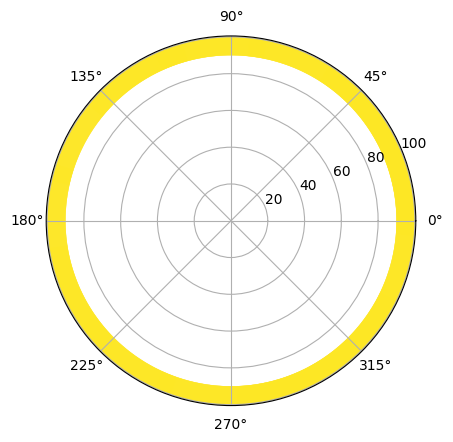

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)

# Compute pie slices
N = 20
theta = np.linspace(0.0, 100, 10)
radii = 10
width = 4
colors = plt.cm.viridis(radii / 10.)

ax = plt.subplot(projection='polar')
ax.bar(theta, radii, width=width, bottom=90, color=colors, alpha=0.5)

plt.show()